# Merging OOI Datasets
By Sage Lichtenwalner, May 20, 2020

Merging datasets is a common task in data analysis, especially when dealing with raw data that hasn't been cleaned or combined by others.  Because the OOI dataset is delivered as collection of independent instruments, each with their own timestamps, this is an essential step for those looking to use OOI data from the [OOI Data Portal](https://ooinet.oceanobservatories.org).

Python has a lot of great tools, but the [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) and [xarray](http://xarray.pydata.org/en/stable/combining.html) guides on merging and combining data are not for the faint of heart.  

Hopefully, this notebook provides you with a simple recipe to follow to create your own combined OOI dataset.

## Introduction

Creating a merged OOI datasets typically involves the following steps:

1. Load and subset all of your desired datasets
2. Align each dataset to the same index or timestep. 
3. Rename the variable columns so they are unique, if necessary.
4. Merge and export, FTW!

So let's get started...

In [1]:
# Notebook setup
import requests
import os
import re
import xarray as xr
!pip install netcdf4

import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1 - Load Datasets
For this example, I'm going to load 1 year of recovered instrument data from 3 CTDs from [Station Papa's Flanking Mooring B](https://oceanobservatories.org/site/gp03flmb/).  Specifically:
* 30m = GP03FLMB-RIM01-02-CTDMOG060
* 60m = GP03FLMB-RIM01-02-CTDMOG062
* 90m = GP03FLMB-RIM01-02-CTDMOG063

To learn more about how to request your own datasets, check out the [How to Request OOI Data](https://github.com/ooi-data-lab/datalab-blog-examples/blob/master/2020/03_How_to_Request_OOI_Data.ipynb) notebook.

I've already requested the datasets from the data portal, so we can just start with the URLs.  

In [0]:
url_30m = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200512T164128069Z-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_60m = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200512T164155426Z-GP03FLMB-RIM01-02-CTDMOG062-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_90m = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200512T164206177Z-GP03FLMB-RIM01-02-CTDMOG063-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

Here is a function that will open up each URL and filter out the files we need to load the dataset.

In [0]:
def get_datalist(url):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets 

In [0]:
ctd30_list = get_datalist(url_30m)
ctd60_list = get_datalist(url_60m)
ctd90_list = get_datalist(url_90m)

The result of this is a list of files we can then pass to `xarray.open_mfdataset()`.  

So now we can load the datasets.

In [0]:
# Load datasets
# Remember, becuase of a quirk of the OOI, we need to swap the primary dimension
ctd30_data = xr.open_mfdataset(ctd30_list).swap_dims({'obs': 'time'})
ctd60_data = xr.open_mfdataset(ctd60_list).swap_dims({'obs': 'time'})
ctd90_data = xr.open_mfdataset(ctd90_list).swap_dims({'obs': 'time'})

In [0]:
# Subset variables
ctd30_data = ctd30_data[['ctdmo_seawater_temperature','practical_salinity','ctdmo_seawater_pressure']]
ctd60_data = ctd60_data[['ctdmo_seawater_temperature','practical_salinity','ctdmo_seawater_pressure']]
ctd90_data = ctd90_data[['ctdmo_seawater_temperature','practical_salinity','ctdmo_seawater_pressure']]

Let's take a quick look at the data we loaded by plotting the Seawater Temperatures.

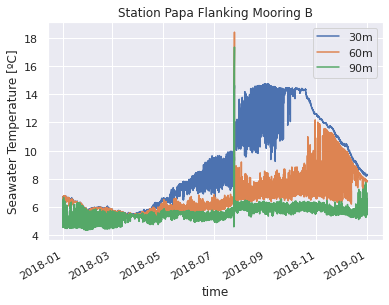

In [7]:
# CTD Temperature Quickplot
ctd30_data.ctdmo_seawater_temperature.plot(label='30m')
ctd60_data.ctdmo_seawater_temperature.plot(label='60m')
ctd90_data.ctdmo_seawater_temperature.plot(label='90m')
plt.legend();
plt.title('Station Papa Flanking Mooring B');

From the quickplot above, we can already see some interesting features in the annual cycle of temperature. 

However, there's also a blip in the dataset when the instruments were redeployed on July 25, and there appears to be an offset in the data that was collected after then.  

We're going to forgo delving into the quality of this dataset for now, but a quick look at the pressure record tells that the mooring was deployed in deeper waters than planned for the first half of 2018.  Thus, the offset in temps is actually a result of the CTDs being deployed at different depths over the course of the year.

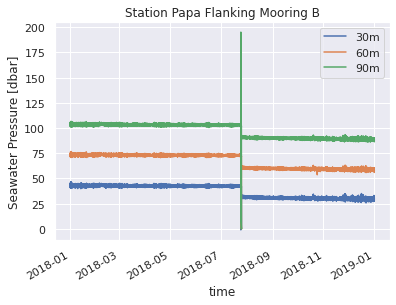

In [8]:
# CTD Pressure Quickplot
ctd30_data.ctdmo_seawater_pressure.plot(label='30m')
ctd60_data.ctdmo_seawater_pressure.plot(label='60m')
ctd90_data.ctdmo_seawater_pressure.plot(label='90m')
plt.legend();
plt.title('Station Papa Flanking Mooring B');

## Step 2 - Align Datasets
Now that our datasets are loaded, we need to align them along the same index.  In this case, we want to match the data points up in time.

If you know your datasets have the same timestamps (even if they don't necessarily have the same shape), you can go straight to merging them.  However, if they don't, you will need to align them first.  

I find the easiest way to do this is to average each dataset to the same frequency, perhaps hourly or daily if that is appropriate for your dataset and analysis goals.  Alternatively you could interpolate your datasets, if that is more appropriate.

Both xarray and python make time-based averaging easy.  In addition, averaging also tends to smooth out some of the "noise" (aka variability), making it a little easier to interpret.  So, to keep things simple, we'll take a daily average for now, but you could easily adjust this to your needs.

To create our averages, we will first convert our xarray Datasets to pandas Dataframes, then take daily (mean) averages.

In [9]:
ctd30_avg = ctd30_data.to_dataframe().resample('1D').mean()
ctd60_avg = ctd60_data.to_dataframe().resample('1D').mean()
ctd90_avg = ctd90_data.to_dataframe().resample('1D').mean()

ctd30_avg.head()

,ctdmo_seawater_temperature,practical_salinity,ctdmo_seawater_pressure,obs
time,,,,
2018-01-01,6.718752,32.483622,43.368250,47.5
2018-01-02,6.773780,32.478026,43.257995,143.5
2018-01-03,6.764915,32.477588,43.057042,239.5
2018-01-04,6.719590,32.481021,43.003448,335.5
2018-01-05,6.639625,32.486711,43.113223,431.5


## Step 3 - Rename Variables (if needed)
In this example, we are trying to combine 3 CTD datasets, all of which have the same variable names.  If we were to merge them now, depending on the function we use to merge the datasets, the columns would either overwrite each other or we'd end up with weird _x, _y, _z variable names that aren't helpful.

To make our final dataset clear, we will rename each column first.

In [0]:
a = ctd30_avg.rename(columns={'ctdmo_seawater_temperature':'Temperature 30m',
                  'practical_salinity':'Salinity 30m',
                  'ctdmo_seawater_pressure':'Pressure 30m'})
b = ctd60_avg.rename(columns={'ctdmo_seawater_temperature':'Temperature 60m',
                  'practical_salinity':'Salinity 60m',
                  'ctdmo_seawater_pressure':'Pressure 60m'})
c = ctd90_avg.rename(columns={'ctdmo_seawater_temperature':'Temperature 90m',
                  'practical_salinity':'Salinity 90m',
                  'ctdmo_seawater_pressure':'Pressure 90m'})

## Step 4 - Merge and Export
Now that we have everything set, we can go ahead and merge our dataset.  For this example, we are going to use `pandas.merge()` which works a little bit like a SQL database query, if you're familiar with those.

First we will merge dataset "A" with dataset "B" aligning them using the "time" column.  The join type of "outer" means that we will take the union of all time indices in both arrays.  If we wanted the intersection of those time stamps that are found in both arrays, we could use "inner".  Because our datasets are complete, in this example either would work.

We then repeat the same process merging the output from AB with C.

In [11]:
# Merge the 3 datasets
data = a.merge(b,on='time',how='outer').merge(c,on='time',how='outer')

# Drop unncessary columns
data = data.drop(['obs_x','obs_y','obs'],axis=1)

# Take a quick sample from the combined dataset
data.sample(5)

,Temperature 30m,Salinity 30m,Pressure 30m,Temperature 60m,Salinity 60m,Pressure 60m,Temperature 90m,Salinity 90m,Pressure 90m
time,,,,,,,,,
2018-02-25,5.866350,32.481166,42.933733,5.824144,32.495195,73.495954,5.043483,32.863129,103.660430
2018-03-03,5.691405,32.502656,42.758308,5.684049,32.509764,73.246636,5.033612,32.836258,103.410061
2018-03-04,5.693979,32.496324,42.714003,5.697621,32.507354,73.261012,4.984207,32.868166,103.424685
2018-11-30,10.575343,31.147500,30.055767,9.133605,32.398438,58.986589,5.743959,32.634452,89.143269
2018-03-13,5.605035,32.497492,42.738881,5.603247,32.503674,73.212178,5.467124,32.588500,103.355206


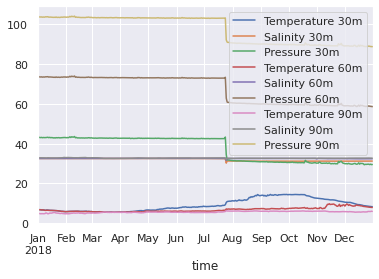

In [12]:
# Quickplot of all columns (just to see what it looks like)
data.plot()

Finally, let's plot the final merged daily averaged dataset.

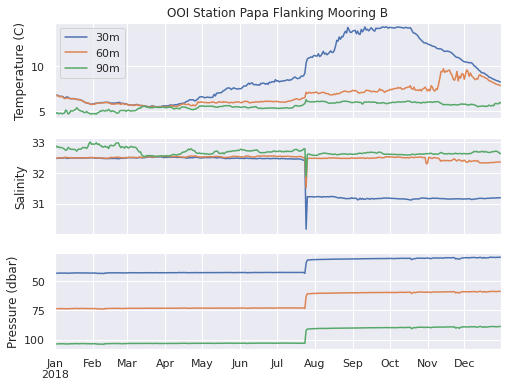

In [13]:
# Plot the final dataset
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(8,6))
data['Temperature 30m'].plot(ax=ax1,label="30m")
data['Temperature 60m'].plot(ax=ax1,label="60m")
data['Temperature 90m'].plot(ax=ax1,label="90m")
data['Salinity 30m'].plot(ax=ax2)
data['Salinity 60m'].plot(ax=ax2)
data['Salinity 90m'].plot(ax=ax2)
data['Pressure 30m'].plot(ax=ax3)
data['Pressure 60m'].plot(ax=ax3)
data['Pressure 90m'].plot(ax=ax3)

ax1.set_ylabel('Temperature (C)')
ax2.set_ylabel('Salinity')
ax3.set_ylabel('Pressure (dbar)')
ax1.legend()
ax3.set_xlabel('')
ax3.invert_yaxis()
ax1.set_title('OOI Station Papa Flanking Mooring B');

plt.savefig('GP03FLMB_CTD.png');

And thanks to pandas, we can easily export our combined dataset to CSV.

In [0]:
data.to_csv('GP03FLMB_CTD.csv')

And so there we have it.  One nicely merged and averaged dataset, ready to use in Excel or another tool or script. 

Before we use this, of course, we really need to take care of the spike on the day the mooring was redeployed, but that's an exercise for another day ;)